In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
from sklearn.metrics import roc_auc_score,roc_curve,auc
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import GradientBoostingClassifier,RandomForestClassifier
from sklearn.model_selection import cross_val_score 
import nltk
nltk.download('wordnet')
nltk.download('omw-1.4') 
nltk.download('punkt')  
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import joblib
np.random.seed(123)

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\lanmo\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\lanmo\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\lanmo\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [2]:
df = pd.read_csv(r"C:\Users\lanmo\Downloads\archive1\IMDB Dataset.csv")

In [3]:
df_preobraz = pd.get_dummies(df,columns = ['sentiment'],drop_first=True,dtype = int)

In [4]:
df_preobraz.head(10)

,review,sentiment_positive
0,One of the other reviewers has mentioned that ...,1
1,A wonderful little production. <br /><br />The...,1
2,I thought this was a wonderful way to spend ti...,1
3,Basically there's a family where a little boy ...,0
4,"Petter Mattei's ""Love in the Time of Money"" is...",1
5,"Probably my all-time favorite movie, a story o...",1
6,I sure would like to see a resurrection of a u...,1
7,"This show was an amazing, fresh & innovative i...",0
8,Encouraged by the positive comments about this...,0
9,If you like original gut wrenching laughter yo...,1


Уберем пунктуацию и br /><br /

In [6]:
def chist(df):
    result = re.sub('<br /><br />|[!.,?\-\(\):]',' ',df).lower()
    reb = re.sub(r'\s+', ' ', result)
    return reb

df_preobraz['chist'] = df_preobraz['review'].apply(chist)

Избавимся от слов паразитов

In [7]:
stop_words = set(stopwords.words('english'))
df_preobraz['bez_slov_paraz'] = df_preobraz['chist'].apply(lambda x:' '.join([i for i in x.split(' ') if i not in stop_words]))

Уберем мешающие окончания

In [8]:
lemma = WordNetLemmatizer()
df_preobraz['lemma'] = df_preobraz['bez_slov_paraz'].apply(lambda x: " ".join([lemma.lemmatize(i,pos='v') for i in x.split(' ')]))

In [9]:
df_text = df_preobraz.drop(columns = ['review','chist','bez_slov_paraz'],axis = 1)

In [10]:
X = df_text.drop('sentiment_positive',axis = 1)
y = df_text['sentiment_positive']

TfidfVectorizer преобразование

In [11]:
vec = TfidfVectorizer(min_df=4 , max_df=0.9)#min_df - отвечает за минимально количество слова в документах, max_df - максимальных процент слов в документах
X_tfid = vec.fit_transform(X['lemma'].to_numpy())

In [12]:
X_tfid.shape

(50000, 34415)

Делим на тестовую и трейновую выборку

In [13]:
X_train,X_test,y_train,y_test = train_test_split(X_tfid,y,shuffle=True,test_size=0.2,stratify=y)

# Отберем лучшую модель

In [14]:
models = [
    ('log',LogisticRegression()),
    ('Rf',RandomForestClassifier()),
    ('boost',GradientBoostingClassifier())
]
result = dict()
for name, model in models:
    result[name] = cross_val_score(model, X=X_train, y=y_train, cv=5)
df_results = pd.DataFrame(result)

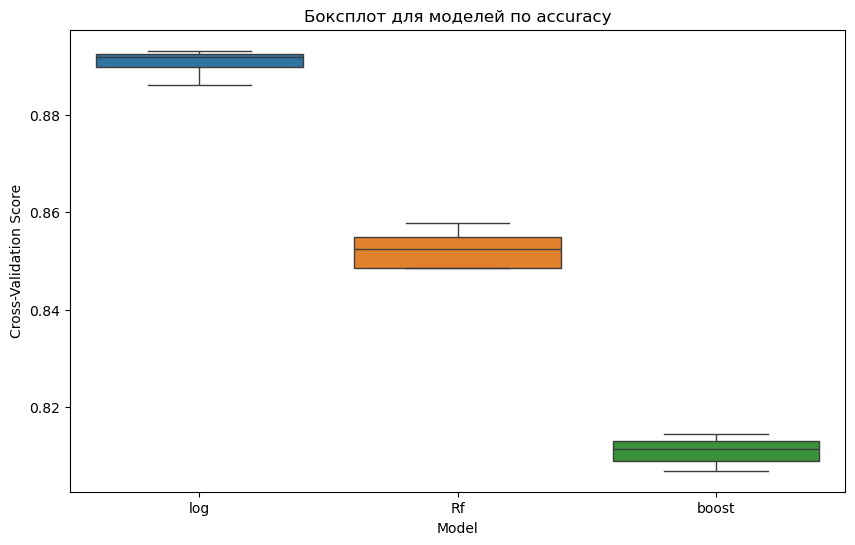

In [15]:
plt.figure(figsize=(10, 6))
sns.boxplot(data=df_results)
plt.title('Боксплот для моделей по accuracy')
plt.ylabel('Cross-Validation Score')
plt.xlabel('Model')
plt.show()

Лучший вариант достигается у логистичекской регрессии поэтому возьмем её

In [16]:
log = LogisticRegression()
log.fit(X_train,y_train)

LogisticRegression()

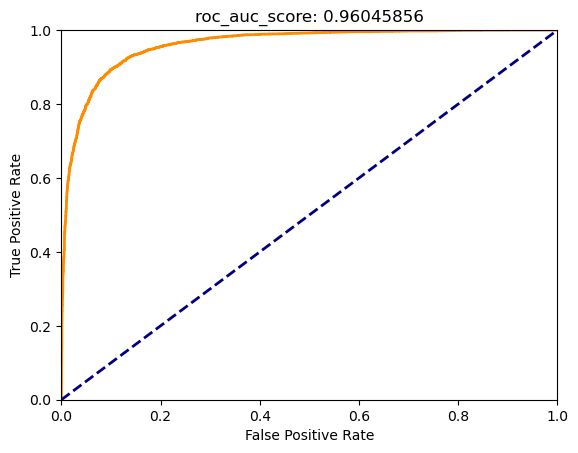

In [17]:
y_prob = log.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')  
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title(f'roc_auc_score: {roc_auc_score(y_test.to_numpy(),log.predict_proba(X_test)[:,1])}')
plt.show()

In [18]:
print(f'accuracy score: {log.score(X_test,y_test)}')

accuracy score: 0.8952


In [19]:
coef = pd.DataFrame(log.coef_.reshape(-1, 1), index=vec.get_feature_names_out(), columns=['Coefficient']).sort_values(by = 'Coefficient',ascending=False)

In [20]:
coef.head(10)

,Coefficient
great,7.783219
excellent,7.222366
best,5.622707
perfect,5.425142
love,5.412015
wonderful,5.365197
amaze,4.933960
enjoy,4.710364
brilliant,4.680667
favorite,4.632435


In [21]:
coef.tail(10)

,Coefficient
worse,-5.489401
fail,-5.666433
nothing,-5.859055
terrible,-6.041298
poor,-6.047329
bore,-7.401888
bad,-8.084056
awful,-8.142558
waste,-9.296270
worst,-10.700978


Заметим, что зависимость между положительными словами и хорошей оценкой, а также отрицательными словами и плохой оценкой есть и очень большая. Вероятность того, что фильм будет плохо оценен если в нем есть слова worst,bad,bore - большая.

In [22]:
import os
os.chdir('C:\data')

In [23]:
#Сохраним модель 
joblib.dump(log,"log1.pkl")

['log1.pkl']

In [24]:
joblib.dump(vec,'vec1.pkl')

['vec1.pkl']